<h1>Titanic - Voorspellen van overlevenden</h1>

In [349]:
#All imports:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

#ignore deprecation warnings:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore")

<h3>De data</h3>
Er zijn 2 data sets klaar gezet, 1 om het model te trainen en 1 om mee te testen. De set om mee te trainen heeft al de overlevings voorspelling per passagier terwijl de test set deze niet heeft 

In [350]:
train_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')
combine = [train_df, test_df]

In [351]:
print(train_df.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


<h3>Beschrijving van de features</h3>
<ul>
    <li>Categorical: Survived, Sex en Embarked</li>
    <li>Ordinal: Pclass</li>
    <li>Numerical: Age, Fare, SibSp en Parch</li>
    <li>Alpha: Ticket en Cabin</li>
</ul>

In [352]:
# preview the data
print(train_df.shape)
train_df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [353]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [354]:
train_df.info()
print('_'*40)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null

<h4>Typefouten</h4>
<ul>
    <li>Name</li>
</ul>
Is hier een aanpassing voor nodig?

<h4>Null en lege waarden</h4>
<ul>
    <li>Cabin</li>
    <li>Age</li>
</ul>
Is hier een aanpassing voor nodig?


In [355]:
#Numerical values:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<h3>Beschrijving van de data</h3>
<h4>Distributie van de numerieke waarden</h4>
<ul>
    <li>891 passagiers in de training set</li>
    <li>Waardes in "Survived" is 0 | 1</li>
    <li>Ongeveer 38% van deze set heeft het overleefd</li>
    <li>> 75% reisde zonder ouders/kinderen</li>
</ul>

In [356]:
#Categorical data:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Sirayanian, Mr. Orsen",male,347082,G6,S
freq,1,577,7,4,644


<h4>Beschrijving van de categorische data</h4>
<ul>
    <li>891 unieke namen</li>
    <li>2 unieke waardes voor Sex, 65% man</li>
    <li>147 unieke cabins</li>
    <li>De meesten zijn ingestapt op locatie S (Southampton)</li>
    <li>Tickets bevatten ongeveer 24% aan duplicaten:</li>
</ul>

In [357]:
train_df['Ticket'].value_counts()[lambda x: x>1]

347082        7
1601          7
CA. 2343      7
CA 2144       6
3101295       6
             ..
PC 17604      2
2691          2
W./C. 6607    2
113789        2
2699          2
Name: Ticket, Length: 134, dtype: int64

<h4>Te valideren aannames</h4>
<ul>
    <li><b>Correlatie</b> Wat is de correlatie van elke feature tov Survival.</li>
    <li><b>Data aanvulling</b>
        <ul>
            <li>Moeten we/kunnen we Age aanvullen?</li>
            <li>Wat doen we met Embarked?</li>
        </ul>
    </li>
    <li><b>Data correctie</b>
        <ul>
            <li>Kunnen we Ticket als feature laten afvallen?</li>
            <li>Kunnen we de Cabin feature uberhaupt gebruiken?</li>
            <li>Passenger Id heeft geen toegevoegde waarde en kan worden laten vallen.</li>
            <li>Wat te doen met de Name feature? Kan een naam een correlatie hebben met de survival rate?</li>
        </ul>
    </li>
    <li><b>Feature creation</b> Kunnen we een aantal features expliciet toevoegen?
        <ul>
            <li>Bijvoorbeeld een feature Familie gebaseerd op de features Parch en SibSp?</li>
            <li>Kunnen we de titel van een persoon uit het naam veld halen en deze gebruiken als nieuwe feature?</li>
            <li>Heeft het zin om op leeftijd te groeperen? Dus om een ordinale feature te maken van de numerieke leeftijds (Age) feature?</li>
        </ul>
    </li>
    <li><b>Generieke aannames:</b> 
        <ul>
            <li>Vrouwen hebben een grotere kans op overleving</li>
            <li>Kinderen jonger dan ... hebben een grotere kans op overleving</li>
            <li>Upper-class passagiers hebben een grotere kans op overleving</li>
        </ul>
    </li>
</ul>

<h4>Correlatie</h4>
Eerst gaan we de correlatie van de verschillende features met de Survival feature bekijken. Zonder aanpassingen aan de data kunnen we dit alleen doen voor features zonder null-waarden. Daarnaast heeft het alleen zin om dit te doen op categorische (Sex), ordinale (Pclass) en discrete (SibSP, Parch) data types.

In [358]:
#Pclass:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


Duidelijk is te zien dat de reis klasse een sterke correlatie heeft voor in ieder geval klasse 1 en ook nog voor klasse 2. Andersom is er uiteraard ook een hoge correlatie voor het niet overleven tov de reis klasse (3).

Dit is een feature welke duidelijk gebruikt kan worden voor de voorspelling.

Dan voor "Sex":

In [359]:
train_df[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


Kijkende naar onze aannames hierboven kunnen we idd zeggen dat vrouwen een (veel) hogere overlevingskans hadden dan mannen. Dit is een feature welke we goed kunnen gebruiken.

Dan SibSp en Parch:

In [360]:
train_df[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [361]:
train_df[["Parch", "Survived"]].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


Uit SibSp en Parch is voor sommige waarden een hogere correlatie te zien maar voor andere waarden is er geen enkele correlatie te zien. Mogelijk kunnen we hier beter, zoals hierboven beschreven, kijken of we hier nieuwe features uit kunnen samen stellen waar meer waarde uit valt te halen

<h4>Visualisatie</h4>
Voor de correlatie tussen numerieke waardes en Survival rate maken we gebruik van visualisatie. Voor Age plotten we een histogram:

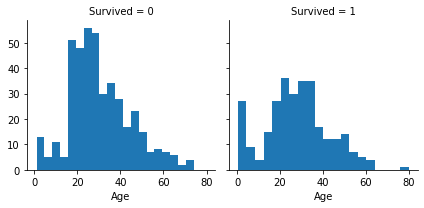

In [362]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

Wat we hier zien:
<ul>
    <li>Kinderen jonger dan 4 jaar oud hebben een hoge overlevingskans</li>
    <li>Iedereen rond de 80 jaar oud heeft het overleefd</li>
    <li>Tussen de 15 en 25 jaar oud is er een groot aantal van niet-overlevenden</li>
    <li>De grootste groep passagiers is tusssen de 15 en 25 jaar oud</li>
</ul>
Kijkende naar de aannames welke we hierboven hebben gedaan:
<ul>
    <li>We kunnen leeftijd als feature gaan gebruiken</li>
    <li>We moeten proberen de ontbrekende leeftijd waardes (null-values) aan te vullen</li>
    <li>Het heeft zin om de leeftijd feature te groeperen</li>
</ul>

<h5>Combinatie van numerieke en ordinale features</h5>
We gaan nu verschillende features combineren in één plot om onderlinge correlaties te proberen te identificeren:

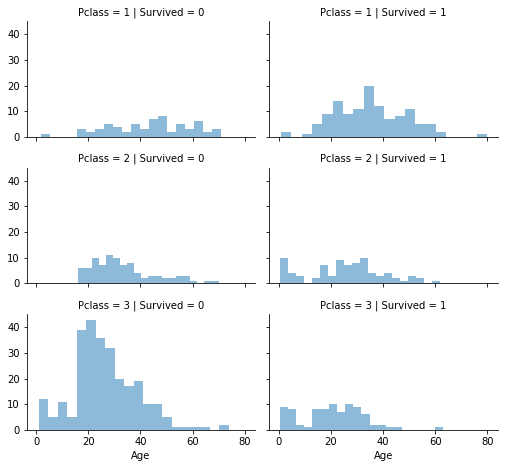

In [363]:
grid = sns.FacetGrid(train_df, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

<ul>
    <li>Klasse 3 heeft ruim de meeste passagiers maar ook ruim het minst aantal overlevenden.</li>
    <li>Alle kinderen in klasse 2 hebben het overleeft. Een redelijk groot deel van de kinderen in klasse 3 heeft het ook overleefd. In klasse 1 kwamen bijna geen kinderen voor</li>
    <li>In klasse 1 zijn relatief de meeste overlevenden zoals ook 1 van onze aannames is</li>
    <li>We zien hier de invloed van leeftijd en klasse gecombineerd op de survival rate</li>
</ul>
Het lijkt er dus op dat we klasse kunnen gebruiken als feature voor ons classificatie probleem

<h5>Correlatie van categorische features</h5>

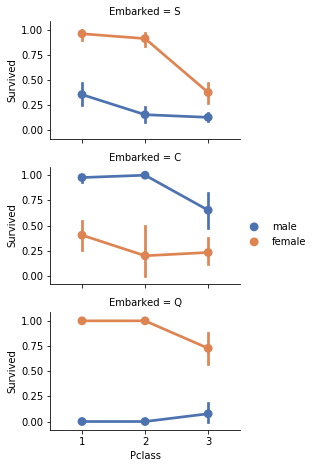

In [364]:
ordered_embarked = train_df["Embarked"].value_counts().index
grid = sns.FacetGrid(train_df, row='Embarked', height=2.2, aspect=1.6, row_order=ordered_embarked)
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep')
grid.add_legend()

<ul>
    <li>Behalve voor de passagiers die in Cherbourg (C) zijn ingestapt is er voor vrouwen een hogere survival rate dan voor mannen</li>
    <li>Dat de survival rate voor mannen hoger is dan voor vrouwen voor Embarked = C kan duiden op een correlatie tussen klasse en embarked en tussen klasse en survived (wat we eerder ook al hadden gezien). Het toont niet direct een correlatie aan tussen embarked en survived.</li>
    <li>Mannelijke overlevingskansen voor klasse 3 in Embarked = Q is hoger dan in klasse 2 (voor Embarked = Q)</li>
</ul>
Sex kan als feature gebruikt worden en Embarked ook. Embarked moet echter wel worden aangevuld gezien de ontbrekende waardes

<h5>Correlatie van categorische en numerieke waardes</h5>
We gaan nu de correlatie van Embarked (categorisch, non-numeriek), Fare (Numeriek, continue) en survival (categorisch numeriek):

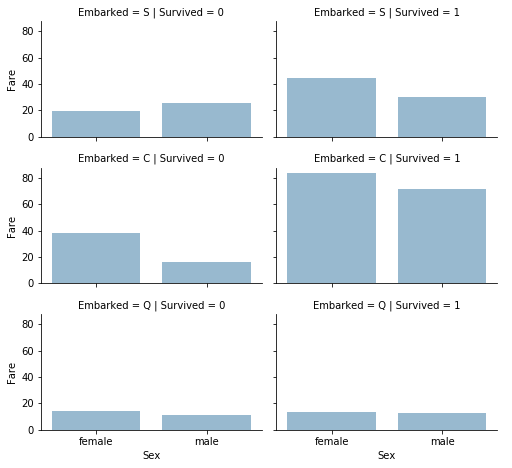

In [365]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', height=2.2, aspect=1.6)
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5, ci=None)
grid.add_legend()

<ul>
    <li>Het is te zien dat een hogere Fare, behalve bij Embarked = Q, een hogere overlevingskans oplevert</li>
    <li>Ook hier is weer te zien dat de plaats van embarkment invloed heeft op de survival rate</li>
</ul>
Fare kunnen we meenemen als feature

<h4>Data correctie, features verwijderen, nieuwe features aanmaken</h4>
Als eerste gaan we de features verwijderen waarvan we hebben gezien dat ze geen of weinig bijdrage leveren aan de voorspelling voor overleving. Gezien de eerdere bevindingen gaan we de Cabin en Ticket features verwijderen, uiteraard op de train én test set:

In [366]:
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

<h5>Aanmaken nieuwe features</h5>
Als eerste kijken we naar het extraheren van de titel uit het naam veld. Als onderdeel van deze oefening kijken we daarna uiteraard ook of er een correlatie tussen de nieuwe feature "title" en survival is te ontdekken.

In [367]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train_df['Title'], train_df['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


Een aantal van deze titels gaan we nu samenvoegen:

In [368]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col',\
 	'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


Omzetten van de categorische titel waarden in ordinale waarden:

In [369]:
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,3
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,3
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,1


Nu het verwijderen van de laatste features welke we niet gaan gebruiken: Name en PassengerId

In [370]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]
train_df.shape, test_df.shape

((891, 9), (418, 9))

We kunnen zien dat sommige titels een goede voorspelling opleveren voor de survival rate (Miss/Mrs vs Mr).

<h5>Omzetten van categorische waarden in numerieke waarden</h5>
Voor Sex gaan we male/female omzetten in 0/1.

In [371]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22.0,1,0,7.2500,S,1
1,1,1,1,38.0,1,0,71.2833,C,3
2,1,3,1,26.0,0,0,7.9250,S,2
3,1,1,1,35.0,1,0,53.1000,S,3
4,0,3,0,35.0,0,0,8.0500,S,1


<h4>Aanvullen van ontbrekende waarden</h4>
Gezien niet alle features waardes hebben voor elke passagier, gaan we nu een aantal invullingen doen, beginnende met de age feature. Er zijn verschillende methoden voor om ontbrekende waarden aan te vullen, hier kiezen we voor het gebruiken van de correlatie welke we eerder hebben gezien tussen Age, Sex en Pclass

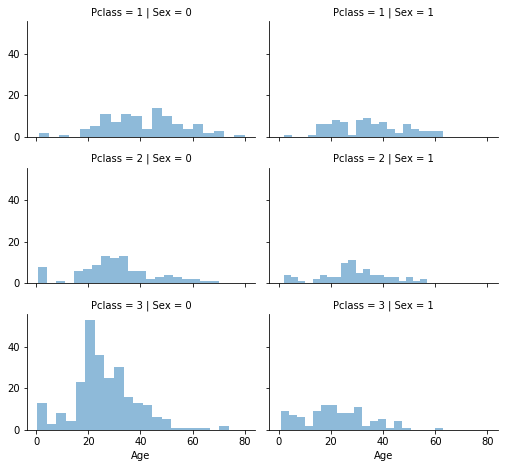

In [372]:
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

Ter ondersteuning:

In [373]:
guess_ages = np.zeros((2,3))
guess_ages

array([[0., 0., 0.],
       [0., 0., 0.]])

In [374]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            guess_df = dataset[(dataset['Sex'] == i) & \
                                  (dataset['Pclass'] == j+1)]['Age'].dropna()

            # age_mean = guess_df.mean()
            # age_std = guess_df.std()
            # age_guess = rnd.uniform(age_mean - age_std, age_mean + age_std)

            age_guess = guess_df.median()

            # Convert random age float to nearest .5 age
            guess_ages[i,j] = int( age_guess/0.5 + 0.5 ) * 0.5
            
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = guess_ages[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,1
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,1


We gaan nu de Age feature omzetten in een nieuwe AgeBand feature waarbij de Age wordt ingedeeld in 5 leeftijdsgroepen:

In [375]:
train_df['AgeBand'] = pd.cut(train_df['Age'], 5)
train_df[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)

,AgeBand,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


En gelijk Age omzetten in ordinale waarden:

In [376]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age']
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeBand
0,0,3,0,1,1,0,7.2500,S,1,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,1,"(32.0, 48.0]"


AgeBand was een tijdelijke feature welke we nu niet meer nodig hebben:

In [377]:
train_df = train_df.drop(['AgeBand'], axis=1)
combine = [train_df, test_df]
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,1,1,0,7.2500,S,1
1,1,1,1,2,1,0,71.2833,C,3
2,1,3,1,1,0,0,7.9250,S,2
3,1,1,1,2,1,0,53.1000,S,3
4,0,3,0,2,0,0,8.0500,S,1


<h5>Toevoegen van een nieuwe feature FamilySize</h5>
Het aantal familieleden wordt bepaald door de som van Parch en SibSp:

In [378]:
for dataset in combine:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


Om het expliciet te maken voegen we ook een feature "IsAlone" toe om aan te geven of een persoon alleen op de boot zit of niet:

In [379]:
for dataset in combine:
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

train_df[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean()

,IsAlone,Survived
0,0,0.505650
1,1,0.303538


De nieuwe feature IsAlone gaan we gebruiken in plaats van FamilySize, Parch en SibSp. Deze laatste 2 gaan we dan ook uit de set verwijderen:

In [380]:
train_df = train_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'FamilySize'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone
0,0,3,0,1,7.2500,S,1,0
1,1,1,1,2,71.2833,C,3,0
2,1,3,1,1,7.9250,S,2,1
3,1,1,1,2,53.1000,S,3,0
4,0,3,0,2,8.0500,S,1,1


De laatste feature welke we gaan toevoegen is Age*Class

In [381]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3,1,3
1,2,2,1
2,3,1,3
3,2,2,1
4,6,2,3
5,3,1,3
6,3,3,1
7,0,0,3
8,3,1,3
9,0,0,2


<h5>Aanvullen van Embarked</h5>
Ook Embarked heeft ontbrekende waarden. Gezien het om 2 records gaat, kiezen we hier voor een andere strategie om deze op te vullen, namelijk gewoon met de meest voorkomende waarden:

In [382]:
freq_port = train_df.Embarked.dropna().mode()[0]
freq_port

'S'

In [383]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(freq_port)
    
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.339009


Nu alleen de categorische waarden in Embarked omzetten naar numeriek:

In [384]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

train_df.head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,7.2500,0,1,0,3
1,1,1,1,2,71.2833,1,3,0,2
2,1,3,1,1,7.9250,0,2,1,3
3,1,1,1,2,53.1000,0,3,0,2
4,0,3,0,2,8.0500,0,1,1,6


<h5>Aanvullen van Fare</h5>
Ook hier vullen we de ontbrekende waarde simpel aan, deze keer met de mediaan:

In [385]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)
test_df.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,7.8292,2,1,1,6
1,893,3,1,2,7.0000,0,3,0,6
2,894,2,0,3,9.6875,2,1,1,6
3,895,3,0,1,8.6625,0,1,1,3
4,896,3,1,1,12.2875,0,3,0,3


Ook voor Fare gaan we een bandbreedte definieren:

In [386]:
train_df['FareBand'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by='FareBand', ascending=True)

,FareBand,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


En dus ook weer omzetten naar numerieke waarden

In [387]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

train_df = train_df.drop(['FareBand'], axis=1)
combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,0,3,0,1,0,0,1,0,3
1,1,1,1,2,3,1,3,0,2
2,1,3,1,1,1,0,2,1,3
3,1,1,1,2,3,0,3,0,2
4,0,3,0,2,1,0,1,1,6
5,0,3,0,1,1,2,1,1,3
6,0,1,0,3,3,0,1,1,3
7,0,3,0,0,2,0,4,0,0
8,1,3,1,1,1,0,3,0,3
9,1,2,1,0,2,1,3,0,0


En ook de test set:

In [388]:
test_df.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,IsAlone,Age*Class
0,892,3,0,2,0,2,1,1,6
1,893,3,1,2,0,0,3,0,6
2,894,2,0,3,1,2,1,1,6
3,895,3,0,1,1,0,1,1,3
4,896,3,1,1,1,0,3,0,3
5,897,3,0,0,1,0,1,1,0
6,898,3,1,1,0,2,2,1,3
7,899,2,0,1,2,0,1,0,2
8,900,3,1,1,0,1,3,1,3
9,901,3,0,1,2,0,1,0,3


<h2>Voorspellen!</h2>
Het heeft even geduurd maar eindelijk zijn de datasets klaar om te gebruiken voor voorspelling.

In [389]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 8), (891,), (418, 8))

We gebruiken nog eerst een regressie voor het valideren van onze aannames voor het aanmaken van nieuwe features en om een overzicht te krijgen welke features sterk bijdragen aan het wel of niet overleven

In [390]:
logreg = LogisticRegression(solver="lbfgs")
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,2.201619
5,Title,0.397888
2,Age,0.287011
4,Embarked,0.261473
6,IsAlone,0.126553
3,Fare,-0.086655
7,Age*Class,-0.311069
0,Pclass,-0.750700


Hierboven is te zien dat als de waarde van Sex verhoogt (0/man naar 1/vrouw), de survival rate het sterkste toeneemt (kans op overleven). Andersom, als de waarde voor Pclass hoger wordt, dan wordt neemt de overlevingskans het sterkste af. De zelf toegevoegde feature Age*Class is ook een goede (negatieve) voorspeller voor de overlevingskans

<h5>Support Vector Machines</h5>
Nu de voorspelling met lineaire SVM

In [391]:
svc = SVC(kernel="rbf", gamma="auto")
svc.fit(X_train, Y_train)
Y_train_pred=svc.predict(X_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
print (acc_svc)

83.84


<h4>Next steps</h4>
<ul>
    <li>Verbeteren van bovenstaande oplossing</li>
    <li>Denk dan aan het toepassen van cross validation</li>
    <li>Denk dan aan parameter tuning</li>
    <li>Andere kernels?</li>
    <li>Zou jij de ontbrekende data op een andere manier aanvullen?</li>
</ul>

<b>Decision trees</b>

In [392]:
from sklearn.ensemble import RandomForestClassifier

rfC = RandomForestClassifier(n_estimators=100)
rfC.fit(X_train, Y_train)
Y_train_pred=rfC.predict(X_train)
Y_pred = rfC.predict(X_test)
acc_svc = round(rfC.score(X_train, Y_train) * 100, 2)
print (acc_svc)

86.76


<b>Visualize</b>

In [393]:
from sklearn.tree import export_graphviz
#from sklearn import tree
estimator = rfC.estimators_[5]
export_graphviz(estimator)

'digraph Tree {\nnode [shape=box] ;\n0 [label="X[7] <= 2.5\\ngini = 0.482\\nsamples = 550\\nvalue = [530, 361]"] ;\n1 [label="X[4] <= 0.5\\ngini = 0.48\\nsamples = 220\\nvalue = [149, 223]"] ;\n0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;\n2 [label="X[5] <= 1.5\\ngini = 0.497\\nsamples = 152\\nvalue = [121, 141]"] ;\n1 -> 2 ;\n3 [label="X[7] <= 0.5\\ngini = 0.354\\nsamples = 73\\nvalue = [97, 29]"] ;\n2 -> 3 ;\n4 [label="X[3] <= 1.5\\ngini = 0.18\\nsamples = 12\\nvalue = [18, 2]"] ;\n3 -> 4 ;\n5 [label="X[3] <= 0.5\\ngini = 0.346\\nsamples = 5\\nvalue = [7, 2]"] ;\n4 -> 5 ;\n6 [label="gini = 0.0\\nsamples = 1\\nvalue = [2, 0]"] ;\n5 -> 6 ;\n7 [label="X[0] <= 2.5\\ngini = 0.408\\nsamples = 4\\nvalue = [5, 2]"] ;\n5 -> 7 ;\n8 [label="gini = 0.0\\nsamples = 1\\nvalue = [2, 0]"] ;\n7 -> 8 ;\n9 [label="gini = 0.48\\nsamples = 3\\nvalue = [3, 2]"] ;\n7 -> 9 ;\n10 [label="gini = 0.0\\nsamples = 7\\nvalue = [11, 0]"] ;\n4 -> 10 ;\n11 [label="X[3] <= 1.5\\ngini = 0.38\\nsamples

<b>Crossvalidation & Grid search</b>

In [394]:
#Imports:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [395]:
# Keep aside known verification data
X_train_part, X_test_part, y_train_part, y_test_part = train_test_split(X_train, Y_train, random_state=43, test_size=0.20)

#Tuning:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': np.logspace(-9, 3, 13),#[1e-3, 1e-4, "auto", np.logspace(-9, 3, 13)],
                     'C': np.logspace(-6, -1, 10)},#[1, 10, 100, 1000, np.logspace(-6, -1, 10)]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
scoringArray = ['balanced_accuracy', "average_precision", "f1", "accuracy", "f1_micro", "f1_weighted"]

In [396]:
#Prepare
skf = StratifiedKFold(n_splits=4, random_state=47, shuffle=True)
# Searching:
resultArray = []
for score in scoringArray:
    print ("Scoring param: {}".format(score))
    clf = GridSearchCV(SVC(), tuned_parameters, cv=None, scoring=score)
    
    cv_results = cross_validate(clf, X_train_part, y_train_part, cv=skf, return_train_score=True, return_estimator=True)
    print (cv_results['test_score'])
    svMax = cv_results['estimator'][np.argmax(cv_results['test_score'])]
                                
                                
    Y_test_pred=svMax.predict(X_test_part)
    acc_svc = round(svMax.score(X_test_part, y_test_part) * 100, 2)
    print (acc_svc)
    resultArray.append({"score":score, "cvResults" : cv_results, "svMax": svMax, "maxScore":np.amax(acc_svc)})



Scoring param: balanced_accuracy
[0.75 0.79 0.81 0.8 ]
69.81
Scoring param: average_precision
[0.79 0.88 0.75 0.83]
71.33
Scoring param: f1
[0.69 0.74 0.76 0.75]
61.29
Scoring param: accuracy
[0.77 0.8  0.75 0.82]
73.18
Scoring param: f1_micro
[0.77 0.8  0.75 0.82]
73.18
Scoring param: f1_weighted
[0.76 0.8  0.82 0.82]
72.47


In [397]:
#Scoring:
overallBest = 0
bestResult = dict()
for result in resultArray:
    if (overallBest < result["maxScore"]):
        overallBest = result["maxScore"]
        bestResult = result
        
print ("Best score: {} with scoring: {}".format(overallBest, bestResult["score"]))
print(svMax)

Best score: 73.18 with scoring: accuracy
GridSearchCV(cv=None, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': array([1.00e-06, 3.59e-06, 1.29e-05, 4.64e-05, 1.67e-04, 5.99e-04,
       2.15e-03, 7.74e-03, 2.78e-02, 1.00e-01]),
                          'gamma': array([1.e-09, 1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02,
       1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
     

<b>Confusion matrix</b>

[[93 17]
 [31 38]]


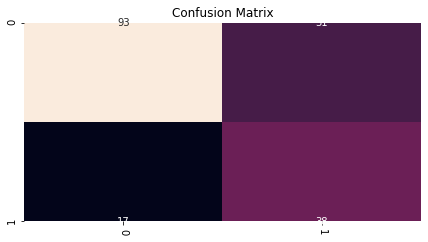

In [398]:
from sklearn.metrics import confusion_matrix
import numpy as np

bestC = bestResult["svMax"]
y_test_pred=svMax.predict(X_test_part)

classes = np.unique(y_test_part)
cm = confusion_matrix(y_test_part, y_test_pred, classes)

title = "Confusion Matrix"

np.set_printoptions(precision=2)
plt.figure()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title(title)
#plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=270)
plt.yticks(tick_marks, classes)

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')


print(cm)
sns.heatmap(cm.T, square=True, annot=True, fmt='d', cbar=False)

In [ ]:
#Prepare
skf = StratifiedKFold(n_splits=4, random_state=47, shuffle=True)
# Searching:

clf = GridSearchCV(SVC(), scoring=scoringArray

In [399]:
, param_grid=tuned_parameters, cv=skf, refit='average_precision')
clf.fit(X_train_part, y_train_part)

print("Best score with {} with params: {}, outcome: {}".format(clf.best_score_, clf.best_params_, clf.best_score_))

svMax = clf.best_estimator_

Y_test_pred=svMax.predict(X_test_part)
acc_svc = round(svMax.score(X_test_part, y_test_part) * 100, 2)
print (acc_svc)

print(svMax)

Best score with 0.8398997906514184 with params: {'C': 1, 'kernel': 'linear'}, outcome: 0.8398997906514184
73.18
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)
